# Compact architectures
## Audio Classification with the NBAC dataset

This notebook performs audio classification on audio fragments of 5 seconds long

In [20]:
# IMPORT ALL LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

## Load the data

In [21]:
# Set sample rate to work with at 8000

SR = 16000

In [22]:
!git clone https://github.com/DavidCastello/NBAC.git

fatal: destination path 'NBAC' already exists and is not an empty directory.


In [23]:
def map_subfolders_to_int(path):
    reversed_labels = {}
    counter = 0

    # Walk through the directory
    for root, dirs, files in os.walk(path):
        # For each subdirectory
        for dir in dirs:
            # Add the subdirectory to the dictionary with the current count as the key
            reversed_labels[counter] = dir
            counter += 1

    return reversed_labels

# Specify your directory path here
directory_path = "/kaggle/working/NBAC/audio"
reversed_labels = map_subfolders_to_int(directory_path)
print(reversed_labels)

{0: 'talking', 1: 'coughing', 2: 'dog bark', 3: 'rain', 4: 'loud breathing', 5: 'siren', 6: 'bed movement', 7: 'traffic', 8: 'wind', 9: 'snoring', 10: 'train', 11: 'sneezing', 12: 'silence'}


In [24]:
NUM_CLASSES = len(reversed_labels)

In [25]:
def reverse_dict(original_dict):
    reversed_dict = {value: key for key, value in original_dict.items()}
    return reversed_dict

# reversed dictionary
labels_dict = reverse_dict(reversed_labels)
print(labels_dict)

{'talking': 0, 'coughing': 1, 'dog bark': 2, 'rain': 3, 'loud breathing': 4, 'siren': 5, 'bed movement': 6, 'traffic': 7, 'wind': 8, 'snoring': 9, 'train': 10, 'sneezing': 11, 'silence': 12}


### Load the wav files

In [26]:
NBAC_FOLDER = '/kaggle/working/NBAC/audio'

In [27]:
def wav_data_loader(directory, sr=SR, normalization=True):
    all_fragments = []
    for root, dirs, _ in os.walk(directory):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
            for file in files:
                file_path = os.path.join(dir_path, file)
                # Load the audio file
                sample, sample_rate = librosa.load(file_path, sr=sr)
                if normalization:
                    # Normalize the waveform
                    sample = librosa.util.normalize(sample)
                # Append the sample and its label (subfolder name) as a tuple
                all_fragments.append((sample, labels_dict[dir]))
    return all_fragments

In [28]:
%%time
nbac_wav_dataset = wav_data_loader(NBAC_FOLDER, normalization=False)
len(nbac_wav_dataset)

CPU times: user 6.14 s, sys: 339 ms, total: 6.48 s
Wall time: 6.48 s


780

In [29]:
len(nbac_wav_dataset)

780

## Train-test split

Creating a first train-test split in the original dataset will be useful for correct data augmentation and pre-processing techniques.

In [30]:
X = [wav[0] for wav in nbac_wav_dataset]
y = [wav[1] for wav in nbac_wav_dataset]

X_train_wav, X_test_wav, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_wav, X_val_wav, y_train, y_val = train_test_split(X_train_wav, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Waveform augmentation

In [31]:
## Noise addition

def add_noise(wav_data, noise_factor):

    # Generate noise signal with the same shape as input waveform
    noise = np.random.normal(0, 1, len(wav_data))

    # Scale noise signal with the permissible noise factor value
    noise *= noise_factor

    # Add noise signal to input waveform
    augmented_wav_data = wav_data + noise

    # Normalize the augmented waveform data
    augmented_wav_data = librosa.util.normalize(augmented_wav_data)

    return augmented_wav_data

def time_shift(audio, p):
    """
    Shift audio to the left or right by a random amount.
    """
    # Calculate the length of the audio array
    length = audio.shape[0]

    # Calculate the maximum number of samples to shift
    max_shift = int(length * p)

    # Generate a random shift value
    shift = random.randint(-max_shift, max_shift)

    # Create an empty array with the same shape as the audio array
    shifted_audio = np.zeros_like(audio)

    # Shift the audio by the specified number of samples
    if shift > 0:
      # Shift to the right
        shifted_audio[shift:] = audio[:length-shift]
    else:
        # Shift to the left
        shifted_audio[:length+shift] = audio[-shift:]
    
    if np.sum(shifted_audio) == 0:
        #revert the process if all information was erased
        shifted_audio = audio     

    return shifted_audio

def time_stretching(audio,factor):
    
    wav_time_stch = librosa.effects.time_stretch(audio,rate=factor)
    
    return wav_time_stch[:SR*5]

In [32]:
len(X_train_wav)

436

In [33]:
%%time
''' EXUCUTE THIS CELL TO APPLY DATA AUGMENTATION
Lots of memory required this step could be optimized'''

def augment_wavs(wav_dataset, y):
    
    y = list(y)
    
    wav_dataset_augmented = []

    for wav in wav_dataset:
        # Create a copy of the original wav to prevent unwanted side effects
        temp_wav = wav.copy()
        temp_wav = add_noise(temp_wav, 0.025) # We want to use values between 0.005 and 0.04
        temp_wav = time_shift(temp_wav, 0.3)  # We want to use a max shift of 30%
        temp_wav = time_stretching(temp_wav, 0.85)

        wav_dataset_augmented.append(temp_wav)

    # Add original wavs to augmented list
    wav_dataset_augmented.extend(wav_dataset)
    
    y = y + y #each spec is being appended at the bottom of the list

    return wav_dataset_augmented, y

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 20 µs


In [34]:
#X_train_wav, y_train = augment_wavs(X_train_wav, y_train)

In [35]:
len(X_train_wav)

436

# Training

## Transfer learning with Imagenet

In [38]:
class LLF(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)

        return log_mel_spectrogram

sample_rate = SR  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
AUDIO_LENGTH = 5

class HLFBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HLFBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.SeparableConv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.SeparableConv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        ])

    def call(self, inputs):
        return self.seq(inputs)

class EmbeddingsBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EmbeddingsBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GlobalAveragePooling2D(),
        ])

    def call(self, inputs):
        return self.seq(inputs)
    
HLF = HLFBlock(name='HLF')
Embeddings = EmbeddingsBlock(name='Embeddings')

# Define the model
model = Sequential([
    LLF(sample_rate, frame_length, frame_step, input_shape=(AUDIO_LENGTH*SR,)),
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Evaluating model trained with 6 samples per class...


2023-07-20 11:03:29.488212: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/Embeddings/sequential_15/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Evaluating model trained with 10 samples per class...


2023-07-20 11:04:00.857630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/Embeddings/sequential_15/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Evaluating model trained with 14 samples per class...


2023-07-20 11:04:30.800298: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/Embeddings/sequential_15/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Evaluating model trained with 18 samples per class...


2023-07-20 11:05:06.135719: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/Embeddings/sequential_15/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Evaluating model trained with 22 samples per class...


2023-07-20 11:05:49.101666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/Embeddings/sequential_15/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Evaluating model trained with 26 samples per class...


2023-07-20 11:06:52.740358: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/Embeddings/sequential_15/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Evaluating model trained with 33 samples per class...


2023-07-20 11:07:48.409677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_23/Embeddings/sequential_15/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


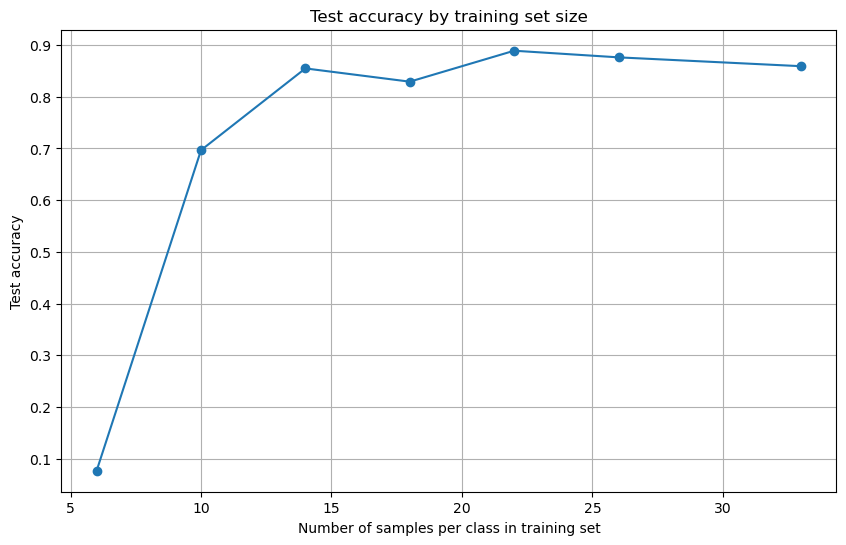

In [39]:
def create_subsets(X, y, num_samples):
    X = np.array(X)
    y = np.array(y)
    classes = np.unique(y)
    X_subsets = []
    y_subsets = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        if len(idx) > num_samples:
            idx = np.random.choice(idx, num_samples, replace=False)
        X_subsets.append(X[idx])
        y_subsets.append(y[idx])
    X_subset = np.concatenate(X_subsets)
    y_subset = np.concatenate(y_subsets)
    X_subset, y_subset = augment_wavs(X_subset, y_subset)
    return X_subset, y_subset

test_accuracies = []
sample_sizes = [6, 10, 14, 18, 22, 26, 33] # INSERT SAMPLE SIZES TO BE TESTED HERE!

for size in sample_sizes:
    print(f'Evaluating model trained with {size} samples per class...')
    # Define the model
    model = Sequential([
        LLF(sample_rate, frame_length, frame_step, input_shape=(AUDIO_LENGTH*SR,)),
        HLF,
        Embeddings,
        tf.keras.layers.Dense(NUM_CLASSES),
        tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Get subset of data and retrain
    X_train_subset, y_train_subset = create_subsets(X_train_wav, y_train, size)
    model.fit(
        np.array(X_train_subset),
        np.array(y_train_subset),
        epochs=50,
        batch_size=32,
        validation_data=(np.array(X_val_wav), np.array(y_val)),
        verbose=0  # we don't need epoch-by-epoch output this time
    )

    # evaluate on the test set
    test_loss, test_acc = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=0)
    test_accuracies.append(test_acc)

# plot test accuracy by training set size
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, test_accuracies, marker='o')
plt.title('Test accuracy by training set size')
plt.xlabel('Number of samples per class in training set')
plt.ylabel('Test accuracy')
plt.grid(True)
plt.show()